In [1]:
from pandas import read_csv

In [2]:
data = read_csv('../Data/credit.csv')
data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',buy_radio_tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',buy_radio_tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',buy_furniture_equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously',buy_new_car,4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [3]:
print(data['class'].value_counts())
data['class'].replace({'good':0, 'bad':1}, inplace=True)
print(data['class'].value_counts())

class
good    700
bad     300
Name: count, dtype: int64
class
0    700
1    300
Name: count, dtype: int64


In [4]:
data.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                      int64
dtype: object

In [5]:
categorical = ['checking_status','credit_history','purpose','savings_status','employment','personal_status',
               'other_parties','property_magnitude','other_payment_plans','housing','job','own_telephone','foreign_worker']
numerical = ['duration','credit_amount','installment_commitment','residence_since','age','existing_credits','num_dependents']

## Feature filtering with statistical tests (chi2, Anova)

In [6]:
from scipy.stats import chi2_contingency, f_oneway
from pandas import crosstab

In [7]:
p_values = []
features = categorical

for f in features:
    contingency_table = crosstab(data['class'], data[f])
    chi2, p, dof, expected = chi2_contingency(contingency_table, correction=False)
    p_values.append((f, p))
    
p_values.sort(key=lambda x:x[1])
for p in p_values:
    print(p)

('checking_status', 1.2189020722893755e-26)
('credit_history', 1.2791872956750916e-12)
('savings_status', 2.7612142385682596e-07)
('property_magnitude', 2.8584415733250017e-05)
('housing', 0.00011167465374597664)
('purpose', 0.00011574910079691586)
('employment', 0.0010454523491402541)
('other_payment_plans', 0.0016293178186473534)
('foreign_worker', 0.009443096254921023)
('personal_status', 0.02223800546926877)
('other_parties', 0.036055954027247226)
('own_telephone', 0.2488438213033109)
('job', 0.5965815918843433)


In [8]:
for c in p_values:
    c = c[0]
    print(c, data[c].nunique())

checking_status 4
credit_history 5
savings_status 5
property_magnitude 4
housing 3
purpose 10
employment 5
other_payment_plans 3
foreign_worker 2
personal_status 4
other_parties 3
own_telephone 2
job 4


In [9]:
p_values = []
features = numerical

# Split samples into two groups. groups from class 0 and class 1
group_a = data.loc[data['class']==0, numerical]
group_b = data.loc[data['class']==1, numerical]
    
F_stat, p_val = f_oneway(group_a, group_b, axis=0)

for p, c in zip(numerical, p_val):
    p_values.append((p, c))
p_values.sort(key=lambda x:x[1])
for p in p_values:
    print(p)

('duration', 6.488049877187189e-12)
('credit_amount', 8.797572373533373e-07)
('age', 0.003925339398278295)
('installment_commitment', 0.022035486306960173)
('existing_credits', 0.1484197860805063)
('num_dependents', 0.9241408780993021)
('residence_since', 0.9253374212983783)


In [10]:
categorical_sel = ['checking_status','credit_history','purpose','savings_status','employment','personal_status',
               'other_parties','property_magnitude','other_payment_plans','housing']
numerical_sel = ['duration','credit_amount','installment_commitment','age']
selected_f = categorical_sel + numerical_sel + ['class']
data_fs = data[selected_f].copy()

## Preprocessing of categorical features to limit number of categories

### Based on EDA in previous project

In [11]:
# purpose
data_fs['purpose'].replace(
{
    'buy_radio_tv': 'low-risk',
    'education': 'normal',
    'buy_furniture_equipment': 'low-risk',
    'buy_new_car': 'low-risk',
    'buy_used_car': 'low-risk',
    'business': 'normal',
    'buy_domestic_appliance': 'normal',
    'repairs': 'normal',
    'other': 'normal',
    'retraining': 'normal'
}, inplace=True)

In [12]:
# credit_history
data_fs['credit_history'].replace(
{
    '\'critical/other existing credit\'': 'good',
    '\'existing paid\'': 'good',
    '\'delayed previously\'': 'good',
    '\'no credits/all paid\'': 'normal',
    '\'all paid\'': 'normal'
}, inplace=True)

## Area under ROC feature forward selection based on candidate features to streamline model for minimum features and max performance. Using logistic regression (a probabilistic model)
* One hot encode
* Split data to train/holdout
* Scaling
* Feature forward selection

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from pandas import get_dummies, concat

In [14]:
# onehot encode
def onehotencode(df, feat):
    new_df = df.copy()
    ohc = get_dummies(df[feat], prefix=feat)
    new_df.drop(columns=feat, inplace=True)
    return concat([new_df, ohc], axis=1)

ohc = categorical_sel
for v in ohc:
    data_fs = onehotencode(data_fs, v)
print(data_fs.columns)

Index(['duration', 'credit_amount', 'installment_commitment', 'age', 'class',
       'checking_status_'0<=X<200'', 'checking_status_'<0'',
       'checking_status_'>=200'', 'checking_status_'no checking'',
       'credit_history_good', 'credit_history_normal', 'purpose_low-risk',
       'purpose_normal', 'savings_status_'100<=X<500'',
       'savings_status_'500<=X<1000'', 'savings_status_'<100'',
       'savings_status_'>=1000'', 'savings_status_'no known savings'',
       'employment_'1<=X<4'', 'employment_'4<=X<7'', 'employment_'<1'',
       'employment_'>=7'', 'employment_unemployed',
       'personal_status_'female div/dep/mar'',
       'personal_status_'male div/sep'', 'personal_status_'male mar/wid'',
       'personal_status_'male single'', 'other_parties_'co applicant'',
       'other_parties_guarantor', 'other_parties_none',
       'property_magnitude_'life insurance'',
       'property_magnitude_'no known property'',
       'property_magnitude_'real estate'', 'property_magnit

In [15]:
# split
y = data_fs[['class']]
x = data_fs.drop(labels='class', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=1)
print(y_train.mean())
print(y_test.mean())
print(y_train.shape, y_test.shape)

class    0.3
dtype: float64
class    0.3
dtype: float64
(750, 1) (250, 1)


In [16]:
# scaling
S = RobustScaler()
S.fit(x_train)
x_train_s = S.transform(x_train)
x_test_s = S.transform(x_test)

In [17]:
from pandas import DataFrame

In [18]:
# Converting scaled data back into dataframes with column names for the next step of feature selection
x_train_s_df = DataFrame(x_train_s, columns=x_train.columns, index=x_train.index)
x_test_s_df = DataFrame(x_test_s, columns=x_test.columns, index=x_test.index)
train = concat([x_train_s_df, y_train], axis=1)
test = concat([x_test_s_df, y_test], axis=1)

# We now have scaled dataframes with x and y, train and test

In [19]:
from numpy import squeeze

In [20]:
# Forward stepwise feature selection

# Scan variables and pick the best
def next_best(current_variables, candidate_variables, target, basetable):
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = area_under_curve(current_variables + [v], target, basetable)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
            
    return best_variable

# Assess area under the curve
def area_under_curve(variables, target, basetable):
    X = basetable[variables].values
    Y = squeeze(basetable[target].values)
    logreg = LogisticRegression(random_state=1)
    logreg.fit(X, Y)
    predictions = logreg.predict_proba(X)[:,1]
    
    auc = roc_auc_score(Y, predictions)
    return auc

In [21]:
# Store the train and test AUC
auc_values_train = []
auc_values_test = []

candidate_variables = list(x_train.columns[1:])
current_variables = []
target = ['class']
number_iterations = len(candidate_variables)
print(number_iterations)

# Iterate over the variables
for i in range(number_iterations):
    # find the next best model with the train data
    next_variable = next_best(current_variables, candidate_variables, target, train)
    current_variables.append(next_variable)
    candidate_variables.remove(next_variable)
    
    # Calculate the train and test AUC of the current of variables
    auc_train = area_under_curve(current_variables, target, train)
    auc_test = area_under_curve(current_variables, target, test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

38


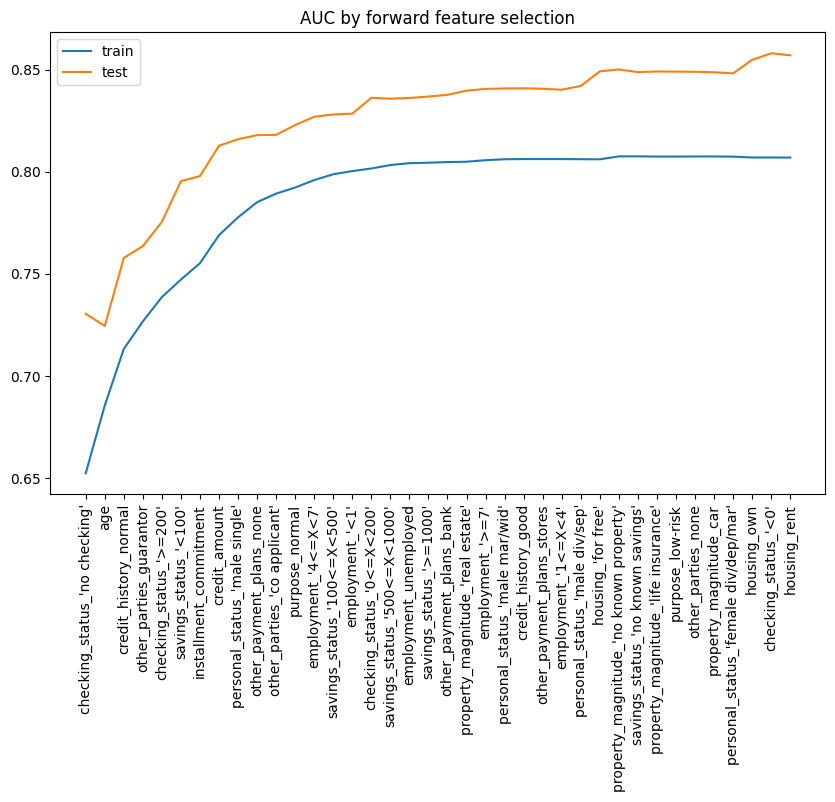

In [22]:
from numpy import array
import matplotlib.pyplot as plt 

x = array(range(0,len(auc_values_train)))
y_train_plot = array(auc_values_train)
y_test_plot = array(auc_values_test)

plt.figure(figsize=(10, 6))
plt.xticks(x, current_variables, rotation=90)
plt.plot(x, y_train_plot, label='train')
plt.plot(x, y_test_plot, label='test')
plt.title('AUC by forward feature selection')

plt.legend(loc="upper left")
plt.show()

## Features to use in model
Based on the above data, Area under ROC curve stops increasing for both train and test data at a 75-25 split after 19 variables on a preprocessed dataset. The 19 variables to use in this model come from the following base features:
* checking_status
* age
* credit_history
* other_parties
* other_payment_plans
* purpose
* employment
* savings_status
* checking_status
* property_magnitude

The 19 variables are:

In [23]:
current_variables[:19]

["checking_status_'no checking'",
 'age',
 'credit_history_normal',
 'other_parties_guarantor',
 "checking_status_'>=200'",
 "savings_status_'<100'",
 'installment_commitment',
 'credit_amount',
 "personal_status_'male single'",
 'other_payment_plans_none',
 "other_parties_'co applicant'",
 'purpose_normal',
 "employment_'4<=X<7'",
 "savings_status_'100<=X<500'",
 "employment_'<1'",
 "checking_status_'0<=X<200'",
 "savings_status_'500<=X<1000'",
 'employment_unemployed',
 "savings_status_'>=1000'"]

## Summary: Feature extraction pipeline

1. Extract these features:
* checking_status
* age
* credit_history
* other_parties
* other_payment_plans
* purpose
* employment
* savings_status
* checking_status
* property_magnitude

2. Engineer credit_history and purpose features based on above transformations

3. Extract the above 19 features

4. Scale data